In [34]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "single"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.su
import curraun.core as core
import curraun.mv as mv
from curraun.correlators import wilson_correlator
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from tqdm import tqdm
import pickle

hbarc = 0.197326

In [57]:
def compute_correlator(M, N, NE):
    # fix g^2 \mu to 1 GeV
    G = 2
    MU = 0.25
    g2mu = G ** 2 * MU

    # simulation parameters
    L = 100.0 / g2mu * hbarc
    DT = 0.125
    UV = 1000000.0
    NUMS = 50
    E0 = N / L * hbarc
    
    # lattice resolution
    gamma = g2mu / E0
    #print("\gamma = g^2 \mu a = {:3.4f}".format(gamma))

    # average wilson correlations
    s = core.Simulation(N, DT, G)
    v_corrs = []
    
    with tqdm(total=NE, file=sys.stdout) as pbar:
        for i in range(NE):
            v = mv.wilson(s, mu=MU / E0, m=M / E0, uv=UV / E0, num_sheets=NUMS)
            v_corr = wilson_correlator(v, N)
            v_corrs.append(v_corr)
            
            pbar.set_description('Event {:3d} / {:3d}'.format(i+1, NE))
            pbar.update(1)

    v_corrs = np.array(v_corrs)
    v_corr_mean = np.mean(v_corrs, axis=0)
    v_corr_std = np.std(v_corrs, axis=0)
    
    output = {'v_corr': v_corr_mean, 'v_corr_std': v_corr_std, 'v_corr_data': v_corrs}
    output['M'] = M
    output['N'] = N
    
    return output

In [55]:
M_values = [0.0, 0.05, 0.1, 0.2]
N = 512
NE = 10

In [56]:
results = []
for m in M_values:
    print("m = {:3.2f} g^2 \mu".format(m))
    r = compute_correlator(m, N, NE)
    results.append(r)

pickle.dump(results, open("wilson_correlators_{}.pickle".format(N), "wb"))

m = 0.00 g^2 \mu
Event   1: 100%|██████████| 2/2 [00:15<00:00,  7.71s/it]
m = 0.05 g^2 \mu
Event   1: 100%|██████████| 2/2 [00:15<00:00,  7.73s/it]
m = 0.10 g^2 \mu
Event   1: 100%|██████████| 2/2 [00:15<00:00,  7.76s/it]
m = 0.20 g^2 \mu
Event   1: 100%|██████████| 2/2 [00:15<00:00,  7.73s/it]


# Momentum space definition of $Q_s$

We use the momentum space definition of $Q_s$ provided in [arXiv:0711.3039](https://arxiv.org/pdf/0711.3039.pdf). We Fourier transform the adjoint representation Wilson line correlator $C(x - y)$, multiply it by $k^2$, average over the polar angle and find the maximum value. 

In [48]:
results = pickle.load(open("wilson_correlators_{}.pickle".format(N), "rb"))

m = 0.0000 g^2 \mu, Q_s / (g^2 \mu) = 1.1947
m = 0.0500 g^2 \mu, Q_s / (g^2 \mu) = 1.0499
m = 0.1000 g^2 \mu, Q_s / (g^2 \mu) = 0.8327
m = 0.2000 g^2 \mu, Q_s / (g^2 \mu) = 0.6155


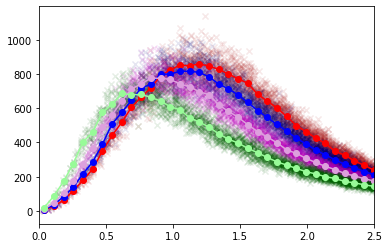

In [66]:
k2 = np.zeros((N, N))
for ix in range(N):
    for iy in range(N):
        k2[ix, iy] = np.sqrt(np.sin((np.pi * ix) / N) ** 2 + np.sin((np.pi * iy) / N) ** 2)
k2 *= 2 / (L / N) * hbarc

colors = ['firebrick', 'navy', 'm', 'darkgreen']
colors2 = ['red', 'blue', 'plum', 'palegreen']

for i, r in enumerate(results):
    v_corr = r['v_corr']
    d_A = curraun.su.N_C ** 2 - 1
    v_fft = np.abs(np.fft.fft2(v_corr)) * d_A
    
    scatter_data = []
    for ix in range(N):
        for iy in range(N):
            scatter_data.append([k2[ix, iy], k2[ix, iy] ** 2 * v_fft[ix, iy]])
    
    scatter_data = np.array(scatter_data)

    bin_means, bin_edges, binnumber = binned_statistic(scatter_data[:, 0], scatter_data[:, 1], bins=200, statistic='mean')
    bin_means = np.nan_to_num(bin_means)
    k = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.scatter(scatter_data[:, 0], scatter_data[:, 1], marker='x', c=colors[i], alpha=0.05)
    plt.xlim([0, 2.5])
    plt.grid()
    plt.plot(k, bin_means, marker='o', c=colors2[i])

    i_max = np.argmax(bin_means)
    Qs = k[i_max]
    print("m = {:3.4f} g^2 \mu, Q_s / (g^2 \mu) = {:3.4f}".format(r["M"], Qs))